In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from library.Data_Preprocessing import Balance_Ratio
from library.Imbalance_Sampling import label_divide, under_over, over_under
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, all_optuna, optuna_history

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### Balance Cascade

In [59]:
# train & test of balance cascade (scheme 1 & 2)
class BalanceCascade:
    
    def __init__(self, base_clf = 'LightGBM', num_iter = 10, over_method = None, under_method = 'NM', 
                 over_num = 5, verbose = True):
        self.classifier = base_clf
        self.num_iter = num_iter
        self.over_method = over_method
        self.under_method = under_method
        self.over_num = over_num if over_method else 1
        self.verbose = verbose
        if over_method not in ['ADASYN', 'SMOTEN', None]:
            raise Exception(f'{over_method} is not implemented !') 
        if under_method not in ['NM', 'random']:
            raise Exception(f'{under_method} is not implemented !') 
        if base_clf not in ['LightGBM', 'RandomForest']:
            raise Exception(f'{base_clf} is not implemented !') 
    
    
    def training(self, train_data, clf_config):
        origin_good = train_data[train_data.GB == 0]
        origin_bad = train_data[train_data.GB == 1] 
        br_0 = (len(origin_bad)*self.over_num) / len(origin_good)
        false_rate = br_0**(1/(self.num_iter - 1))
        
        keep_bad = origin_bad.copy()
        keep_good = {0: origin_good.copy()}
        br_list = []
        clf_threshold = []
        clf_cascade = {}
        for j in range(self.num_iter):
            temp_train = pd.concat([keep_good[j], keep_bad], axis = 0)
            temp_br = len(keep_bad) / len(keep_good[j])
            br_list.append(temp_br)
            
            # oversampling
            if all([self.over_method, len(keep_good[j]) > len(keep_bad)]):
                if self.verbose:
                    print(f'\nIteration {j+1}:')
                over_ratio = np.min([br_list[j]*self.over_num, 0.99])
                over_X, over_Y = under_over(temp_train, self.over_method, None, over_ratio, 0)
                over_sample = pd.concat([over_X, over_Y], axis = 1)
                over_sample = over_sample.rename({0: 'GB'}, axis = 'columns')
                over_bad = over_sample[over_sample.GB == 1]
            else:
                over_bad = keep_bad.copy()
                if self.verbose:
                    print('Stop Oversampling !')
                    print('Size before Undersampling:', len(temp_train))
            temp_combine = pd.concat([keep_good[j], over_bad], axis = 0)
            
            # undersampling
            if all([j != (self.num_iter - 1), len(keep_good[j]) > len(over_bad)]):
                # under_ratio = len(keep_bad) / len(over_bad)
                under_ratio = 1
                under_X, under_Y = over_under(temp_combine, None, self.under_method, 0, under_ratio)
                train_combine = pd.concat([under_X, under_Y], axis = 1)
            else:
                train_combine = temp_combine.copy()
                if self.verbose:
                    print('Stop Undersampling !')
            
            # train the base learner, find the threshold, and discard the redundant good instances
            valid_good = keep_good[j].copy()
            train_x, train_y, valid_x, valid_y = label_divide(train_combine, valid_good, 'GB', train_only = False)
            if self.classifier == 'LightGBM':
                clf = LGBMClassifier(**clf_config)
            elif self.classifier == 'RandomForest':
                clf = RandomForestClassifier(**clf_config)
            clf.fit(train_x, train_y)
            predict = clf.predict_proba(valid_x)[:, 1]
            predict_df = pd.DataFrame(dict(predict = predict), index = valid_x.index)
            predict_df = predict_df.sort_values(by = 'predict', ascending = False)
            keep_num = int(len(predict_df)*false_rate) + 1
            keep_index = predict_df.index[:keep_num]
            threshold = predict_df.loc[keep_index[-1]].values[0]
            clf_threshold.append(threshold)
            clf_cascade[j] = clf
            
            if j != (self.num_iter - 1):
                keep_good[j+1] = keep_good[j].loc[keep_index].copy()        
        self.good_data = keep_good
        self.bad_data = keep_bad
        self.threshold = clf_threshold
        self.cascade = clf_cascade
        self.balance_ratio = br_list
    
    
    def testing(self, test_data):
        clf_cascade = self.cascade
        if isinstance(self.threshold, int):
            clf_threshold = [self.threshold]*len(clf_cascade)
        else:
            clf_threshold = self.threshold

        test_x, test_y = label_divide(test_data, 'GB', train_only = True)
        predict_df = pd.DataFrame()
        for i in range(len(clf_cascade)):
            clf = clf_cascade[i]
            predict = clf.predict_proba(test_x)[:, 1]
            answer = (predict > clf_threshold[i]).astype(int)
            predict = pd.DataFrame({str(i): answer})
            predict_df = pd.concat([predict_df, predict], axis = 1)
        predict_y = (predict_df.apply(sum, axis = 1) == len(clf_cascade)).astype(int)
        result = pd.DataFrame(dict(predict = predict_y, truth = test_y))

        return result


# run all resampling datasets
def runall_cascade(train_set, test_data, base_config, base_clf = 'LightGBM', num_iter = 10, meta_config = None):
    
    num_set = len(train_set)
    table_set = pd.DataFrame()
    for i in range(1, num_set):
        print('\n', f'Dataset {i}:')
        if isinstance(meta_config, dict):
            BC = BalanceCascade(base_clf = base_clf, **meta_config[f'set{i}'])
        else:
            BC = BalanceCascade(base_clf = base_clf, num_iter = num_iter)
        BC.training(train_set[f'set{i}'], base_config[f'set{i}'])
        result = BC.testing(test_data)
        table = cf_matrix(result, train_set[f'set{i}'].GB)
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})
    
    return table_set

### Optuna

In [137]:
# creator of optuna study for balance cascade
def BalanceCascade_creator(train_data, mode, num_valid = 3, label = 'GB') :

    def objective(trial) :
    
        base_param = {
            'n_estimators': trial.suggest_categorical('n_estimators', [100, 300, 500, 1000]),
            'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.325, step = 0.05),
            'max_depth': trial.suggest_int('max_depth', 3, 12, step = 3),
            'num_leaves': trial.suggest_int('num_leaves', 10, 130, step = 20),
            'min_child_samples': trial.suggest_categorical('min_child_samples', [10, 50, 100, 500, 1000, 5000]),
            'min_split_gain': trial.suggest_int('min_split_gain', 0, 12, step = 2),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9, step = 0.2),
            'subsample': trial.suggest_float('subsample', 0.3, 0.9, step = 0.2),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10), # alpha
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10) # lambda
        }
    
        meta_param = {
            'num_iter': trial.suggest_int('num_iter', 5, 5, step = 5),
            'over_num': trial.suggest_int('over_num', 5, 5, step = 5),
            'over_method': trial.suggest_categorical('over_method', ['ADASYN']),
            'under_method': trial.suggest_categorical('under_method', ['random'])
        }  

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)
            all_train = pd.concat([train_x, train_y], axis = 1)
            all_valid = pd.concat([valid_x, valid_y], axis = 1)

            if mode == 1:
                BC = BalanceCascade(num_iter = meta_param['num_iter'], under_method = meta_param['under_method'])
            elif mode == 2:
                BC = BalanceCascade(num_iter = meta_param['num_iter'], over_method = meta_param['over_method'], 
                                    under_method = meta_param['under_method'], over_num = meta_param['over_num'])
            BC.training(all_train, base_param)
            result = BC.testing(all_valid)
            table = cf_matrix(result, valid_y)
            recall = table['Recall'].values
            precision = table['Precision'].values
            beta = 1
            if recall > 0:
                fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision) 
            else:
                fscore = 0
            result_list.append(fscore)

        return np.mean(result_list)
    return objective

## 

### Load Data

In [61]:
### training data ###
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (3795, 88)  balance ratio: 10.0
Dimension of dataset 2 : (3718, 88)  balance ratio: 10.0
Dimension of dataset 3 : (3784, 88)  balance ratio: 10.0
Dimension of dataset 4 : (3784, 88)  balance ratio: 10.0
Dimension of dataset 5 : (3799, 88)  balance ratio: 9.89
Dimension of dataset 6 : (3796, 88)  balance ratio: 9.97
Dimension of dataset 7 : (3789, 88)  balance ratio: 10.18
Dimension of dataset 8 : (3795, 88)  balance ratio: 10.0
Dimension of dataset 9 : (759, 88)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (6314, 97)  balance ratio: 10.0
Dimension of dataset 2 : (6171, 97)  balance ratio: 10.0
Dimension of dataset 3 : (6204, 97)  balance ratio: 10.0
Dimension of dataset 4 : (6204, 97)  balance ratio: 10.0
Dimension of dataset 5 : (6229, 97)  balance ratio: 9.

### Search for The Best Hyperparameters

In [138]:
best_paramC, all_scoreC = all_optuna(all_data = run_train, 
                                     mode = 1, 
                                     TPE_multi = False, 
                                     n_iter = 25,
                                     filename = 'runhist_array_m2m4_m5_3criteria_scheme1_iter5_over5_rus_BalanceCascade',
                                     creator = BalanceCascade_creator
                                    )

meta_item = ['num_iter', 'over_num', 'over_method', 'under_method']
base_paramC = {}
meta_paramC = {}
for i in range(1, len(run_train)):
    base_paramC.update({f'set{i}': {}})
    meta_paramC.update({f'set{i}': {}})
    [base_paramC[f'set{i}'].update({a: b}) for (a, b) in best_paramC[f'set{i}'].items() if a not in meta_item]
    [meta_paramC[f'set{i}'].update({a: b}) for (a, b) in best_paramC[f'set{i}'].items() if a in meta_item]

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-03-14 10:23:21,135] A new study created in memory with name: no-name-4d1507ac-6bc6-4fa1-b173-808d6be7fcb6


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag



Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision:

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:23:22,658] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.02207600052547567, 'reg_lambda': 1.4975254909020732, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 0 with value: 0.0.
Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0.03821656050955414 
Recall: 0.08 
Aging Rate: 0.15169082125603864
Stop Oversampling !
Size before Undersampling: 1272

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12721


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0.08333333333333333 
Recall: 0.027777777777777776 
Aging Rate: 0.023255813953488372
[I 2022-03-14 10:23:30,543] Trial 3 finished with value: 0.013888888888888888 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.43524045021166, 'reg_lambda': 0.14507801064580744, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 1 with value: 0.0539167782148459.
Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:23:32,045] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 7.883787211057054, 'reg_lambda': 0.649945345957214, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 1 with value: 0.0539167782148459.
Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:23:33,550] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.5631484188259356, 'reg_lambda': 0.03979320777323755, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 1 with value: 0.0539167782148459.
Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Si

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


[I 2022-03-14 10:23:38,403] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 2.4670246183763873, 'reg_lambda': 0.05712331921930875, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 1 with value: 0.0539167782148459.
Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12721


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


[I 2022-03-14 10:23:39,935] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 3.3867224945465155, 'reg_lambda': 0.3828745356727642, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 1 with value: 0.0539167782148459.
Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:23:41,608] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 8.914997000159419, 'reg_lambda': 0.1106543404396973, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 1 with value: 0.0539167782148459.
Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0.047619047619047616 

Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0.028409090909090908 
Recall: 0.06172839506172839 
Aging Rate: 0.16311399443929564
Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0.04666666666666667 
Recall: 0.07865168539325842 
Aging Rate: 0.14111006585136407
Stop Oversampling !
Size before Undersampling: 12721
S

Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0.04827586206896552 
Recall: 0.07 
Aging Rate: 0.13757115749525617
Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0.023255813953488372 
Recall: 0.03296703296703297 
Aging Rate: 0.12403846153846154
[I 2022-03-14 10

Stop Undersampling !
Precision: 0.03550295857988166 
Recall: 0.07142857142857142 
Aging Rate: 0.15280289330922242
Stop Oversampling !
Size before Undersampling: 12721
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 7659
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 4813
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 3213
Size after Undersampling: 2312
Stop Oversampling !
Size before Undersampling: 2313
Stop Undersampling !
Precision: 0.05056179775280899 
Recall: 0.0967741935483871 
Aging Rate: 0.1636029411764706
[I 2022-03-14 10:24:14,914] Trial 22 finished with value: 0.05189749947675606 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.05203153111479031, 'reg_lambda': 3.5091415867109617, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'u

[I 2022-03-14 10:24:18,707] A new study created in memory with name: no-name-1e846bf1-2336-425a-b887-fb7162cb1eb1


Precision: 0.033112582781456956 
Recall: 0.0625 
Aging Rate: 0.1444976076555024
[I 2022-03-14 10:24:18,627] Trial 24 finished with value: 0.050871714806141034 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.9544055093475139, 'reg_lambda': 0.6730744322059847, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 16 with value: 0.06560083037609922.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !
Precision: 0.024390243902439025 
Recall: 0.012195121951219513 
Aging Rate: 0.03871576959395656
Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !
Precision: 0.11764705882352941 
Recall: 0.06741573033707865 
Aging Rate: 0.04985337243401759


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.019230769230769232
[I 2022-03-14 10:24:20,814] Trial 0 finished with value: 0.03399148277197058 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 10, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 6.160809080739778, 'reg_lambda': 3.5635074484703595, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 0 with value: 0.03399148277197058.
Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0018744142455482662
Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !
Precision: 0.058823529411764705 
Recall: 0.013888888888888888 
Aging Rate: 0.01691542288557214
Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !
Precision: 0.03333333333333333

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.007633587786259542
[I 2022-03-14 10:24:28,477] Trial 4 finished with value: 0.037125099069786845 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 2.0576873847938995, 'reg_lambda': 0.0684021053388154, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 3 with value: 0.07280426772259803.
Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !
Precision:

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:24:30,018] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.4326534375068041, 'reg_lambda': 0.2749743676159297, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 3 with value: 0.07280426772259803.
Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !
Precision: 0.0547945205479452 
Recall: 0.047058823529411764 
Aging Rate: 0.07285429141716566
Stop Oversampling !

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:24:33,288] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 3.0799098729427707, 'reg_lambda': 0.018947746790867578, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 3 with value: 0.07280426772259803.
Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !
Precision: 0.03389830508474576 
Recall: 0.024390243902439025 
Aging Rate: 0.0575609756097561
Stop Over

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:24:36,854] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 2.9954681638444787, 'reg_lambda': 0.06269978392693233, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 3 with value: 0.07280426772259803.
Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !

Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !
Precision: 0.041666666666666664 
Recall: 0.011235955056179775 
Aging Rate: 0.023323615160349854
Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !
Precision: 0.06493506493506493 
Recall: 0.05952380952380952 
Aging Rate: 0.07277882797731569

Precision: 0.0625 
Recall: 0.05 
Aging Rate: 0.0622568093385214
Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !
Precision: 0.0625 
Recall: 0.0379746835443038 
Aging Rate: 0.045845272206303724
Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !
Precision: 0.04 
Recall: 0.03333333333333333

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !
Precision: 0.037037037037037035 
Recall: 0.012048192771084338 
Aging Rate: 0.026341463414634145
Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !
Precision: 0.06666666666666667 
Recall: 0.041666666666666664 
Aging Rate: 0.0446871896722939

Stop Undersampling !
Precision: 0.0759493670886076 
Recall: 0.07142857142857142 
Aging Rate: 0.07530981887511916
Stop Oversampling !
Size before Undersampling: 12432
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 7486
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 4705
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 3141
Size after Undersampling: 2260
Stop Oversampling !
Size before Undersampling: 2261
Stop Undersampling !
Precision: 0.06944444444444445 
Recall: 0.06666666666666667 
Aging Rate: 0.06963249516441006
[I 2022-03-14 10:25:02,044] Trial 23 finished with value: 0.058515049290313335 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 1.5376023918767825, 'reg_lambda': 0.022367998160778765, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN',

[I 2022-03-14 10:25:03,743] A new study created in memory with name: no-name-fc9c8b37-b887-4e65-91c9-0826a3a26760


Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Stop Oversampling !
Size before Undersampling: 12507
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 7531
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 4733
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 3160
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 2275
Stop Undersampling !
Precision: 0.02459016393442623 
Recall: 0.03125 
Aging Rate: 0.11925708699902249
Stop Oversampling !
Size before Undersampling: 12507
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 7531
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 4733
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 3160
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 2275
Stop Undersampling !
Precision: 0.02142857142857143 
Recall: 0.0379746835443038 
Aging Rate: 0.13793103448275862
Stop Oversampli

Stop Oversampling !
Size before Undersampling: 12507
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 7531
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 4733
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 3160
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 2275
Stop Undersampling !
Precision: 0.05806451612903226 
Recall: 0.10588235294117647 
Aging Rate: 0.14678030303030304
Stop Oversampling !
Size before Undersampling: 12507
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 7531
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 4733
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 3160
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 2275
Stop Undersampling !
Precision: 0.031746031746031744 
Recall: 0.05194805194805195 
Aging Rate: 0.12292682926829268
[

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 4733
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 3160
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 2275
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12507
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 7531
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 4733
Size after Undersampling: 2274


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 3160
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 2275
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:25:14,709] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.7971893485578326, 'reg_lambda': 1.6192025843833215, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 4 with value: 0.05615430701637599.
Stop Oversampling !
Size before Undersampling: 12507
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 7531
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 4733
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 3160
Size after Undersampling: 2274
Stop Oversampling !


Stop Oversampling !
Size before Undersampling: 12507
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 7531
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 4733
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 3160
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 2275
Stop Undersampling !
Precision: 0.034013605442176874 
Recall: 0.06666666666666667 
Aging Rate: 0.14271844660194175
Stop Oversampling !
Size before Undersampling: 12507
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 7531
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 4733
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 3160
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 2275
Stop Undersampling !
Precision: 0.027210884353741496 
Recall: 0.04395604395604396 
Aging Rate: 0.14080459770114942


Stop Oversampling !
Size before Undersampling: 12507
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 7531
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 4733
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 3160
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 2275
Stop Undersampling !
Precision: 0.015384615384615385 
Recall: 0.024096385542168676 
Aging Rate: 0.12464046021093
Stop Oversampling !
Size before Undersampling: 12507
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 7531
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 4733
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 3160
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 2275
Stop Undersampling !
Precision: 0.057692307692307696 
Recall: 0.06451612903225806 
Aging Rate: 0.09876543209876543
[I

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12507
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 7531
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 4733
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 3160
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 2275
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12507
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 7531
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 4733
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 3160
Size after Undersampling: 2274


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 2275
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:25:33,873] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 4.821120074163962, 'reg_lambda': 1.106881585123204, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 12 with value: 0.06872302844601312.
Stop Oversampling !
Size before Undersampling: 12507
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 7531
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 4733
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 3160
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 2275
Stop Undersampling !
Precision: 0.02976

Stop Oversampling !
Size before Undersampling: 12507
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 7531
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 4733
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 3160
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 2275
Stop Undersampling !
Precision: 0.02127659574468085 
Recall: 0.03296703296703297 
Aging Rate: 0.13505747126436782
Stop Oversampling !
Size before Undersampling: 12507
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 7531
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 4733
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 3160
Size after Undersampling: 2274
Stop Oversampling !
Size before Undersampling: 2275
Stop Undersampling !
Precision: 0.013888888888888888 
Recall: 0.025 
Aging Rate: 0.13953488372093023
Stop Oversampli

[I 2022-03-14 10:25:40,997] A new study created in memory with name: no-name-604ef7a4-667a-496e-94e1-858708457f92


[I 2022-03-14 10:25:40,908] Trial 24 finished with value: 0.036278496964142516 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.4492486010748142, 'reg_lambda': 9.671876539083494, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 12 with value: 0.06872302844601312.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Stop Oversampling !
Size before Undersampling: 12523
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 7540
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 4738
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 3163
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 2277
Stop Undersampling !
Precision: 0.04597701149425287 
Recall: 0.044444444444444446 
Aging Rate: 0.08365384615384615
Stop Oversampling !
Size before Undersampling: 12523
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 7540
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 4738
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 3163
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 2277
Stop Undersampling !
Precision: 0.07936507936507936 
Recall: 0.09900990099009901 
Aging Rate: 0.11423390752493201
S

Precision: 0.049586776859504134 
Recall: 0.057692307692307696 
Aging Rate: 0.11897738446411013
Stop Oversampling !
Size before Undersampling: 12523
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 7540
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 4738
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 3163
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 2277
Stop Undersampling !
Precision: 0.03007518796992481 
Recall: 0.04597701149425287 
Aging Rate: 0.12606635071090047
Stop Oversampling !
Size before Undersampling: 12523
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 7540
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 4738
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 3163
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 2277
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Stop Oversampling !
Size before Undersampling: 12523
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 7540
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 4738
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 3163
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 2277
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12523
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 7540
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 4738
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 3163
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 2277
Stop Undersampling !
Precision: 0.0625 
Recall: 0.02040816326530612 
Aging Rate: 0.030447193149381543
[I 2022-03-14 10:25:54,901] Trial 5 finished with value: 0.010256410256410256 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.042427196181399535, 'reg_lambda': 0.045257700952092715, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 1 with value: 0.07945340298281474.
St

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12523
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 7540
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 4738
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 3163
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 2277
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12523
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 7540
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 4738
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 3163
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 2277


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:26:03,659] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.021142636873194582, 'reg_lambda': 0.5270114035991014, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 1 with value: 0.07945340298281474.
Stop Oversampling !
Size before Undersampling: 12523
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 7540
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 4738
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 3163
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 2277
Stop Undersampling !
Precision: 0.02127659574468085 
Recall: 0.012987012987012988 
Aging Rate: 0.04450

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12523
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 7540
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 4738
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 3163
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 2277
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size before Undersampling: 12523
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 7540
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 4738
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 3163
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 2277
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:26:12,940] Trial 13 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 1.7993301758992657, 'reg_lambda': 1.6926266033077944, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 1 with value: 0.07945340298281474.
Stop Oversampling !
Size before Undersampling: 12523
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 7540
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 4738
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 3163
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 2277
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 7540
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 4738
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 3163
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 2277
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12523
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 7540
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 4738
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 3163
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 2277
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.012935323383084577
[I 2022-03-14 10:26:14,480] Trial 14 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.011788013681016639, 'reg_lambda': 0.15430414912789756, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 1 with value: 0.07945340298281474.
Stop Oversampling !
Size before Undersampling: 12523
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 7540
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 4738
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 3163
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 2277
Stop Undersampling !
Precision: 0.04285714285714286 
Recall: 0.039473684210526314 
Aging Rate: 0.06903

Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 7540
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 4738
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 3163
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 2277
Stop Undersampling !
Precision: 0.034482758620689655 
Recall: 0.03529411764705882 
Aging Rate: 0.08123249299719888
Stop Oversampling !
Size before Undersampling: 12523
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 7540
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 4738
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 3163
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 2277
Stop Undersampling !
Precision: 0.024691358024691357 
Recall: 0.02531645569620253 
Aging Rate: 0.07902439024390244
Stop Oversampling !
Size before Undersampling: 12523


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Stop Oversampling !
Size before Undersampling: 12523
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 7540
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 4738
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 3163
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 2277
Stop Undersampling !
Precision: 0.020202020202020204 
Recall: 0.023529411764705882 
Aging Rate: 0.09357277882797732
Stop Oversampling !
Size before Undersampling: 12523
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 7540
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 4738
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 3163
Size after Undersampling: 2276
Stop Oversampling !
Size before Undersampling: 2277
Stop Undersampling !
Precision: 0.06578947368421052 
Recall: 0.056818181818181816 
Aging Rate: 0.07063197026022305

[I 2022-03-14 10:26:33,503] A new study created in memory with name: no-name-631297cd-200a-4c15-aa91-a1802eed1138


Precision: 0.03529411764705882 
Recall: 0.03571428571428571 
Aging Rate: 0.08056872037914692
[I 2022-03-14 10:26:33,425] Trial 24 finished with value: 0.02712222718591276 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 2.7013437882223448, 'reg_lambda': 0.08075757652793271, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 17 with value: 0.0870640844568684.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Stop Oversampling !
Size before Undersampling: 12555
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 2311
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12555


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 2311
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12555


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 2311
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


[I 2022-03-14 10:26:34,994] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.01222327169280418, 'reg_lambda': 0.20556208376077198, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 0 with value: 0.0.
Stop Oversampling !
Size before Undersampling: 12555
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 2311
Stop Undersampling !
Precision: 0.027210884353741496 
Recall: 0.05970149253731343 
Aging Rate: 0.1467065868263473
Stop Oversampling !
Size before Undersampling: 12555
Size after Unde

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12555
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 2311
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12555
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 2311
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:26:42,050] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.01223785834406254, 'reg_lambda': 1.1776420542371242, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 1 with value: 0.04041190723433714.
Stop Oversampling !
Size before Undersampling: 12555
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 2311
Stop Undersampling !
Precision: 0.016 
Recall: 0.023255813953488372 
Aging Rate: 0.12413108242303873
Stop Oversampling !
Size

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12555
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 2311
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12555


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 2311
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


[I 2022-03-14 10:26:45,705] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.1437998676445913, 'reg_lambda': 2.7464857992170875, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 1 with value: 0.04041190723433714.
Stop Oversampling !
Size before Undersampling: 12555
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 2311
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12555


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 2311
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12555
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 2311
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:26:47,249] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 1.269678850647655, 'reg_lambda': 4.9345563894290425, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 1 with value: 0.04041190723433714.
Stop Oversampling !
Size before Undersampling: 12555
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Si

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12555
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 2311
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12555


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 2311
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:26:48,945] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 6.224789364242809, 'reg_lambda': 0.11964308754906045, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 1 with value: 0.04041190723433714.
Stop Oversampling !
Size before Undersampling: 12555
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Ov

Stop Oversampling !
Size before Undersampling: 12555
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 2311
Stop Undersampling !
Precision: 0.01639344262295082 
Recall: 0.020618556701030927 
Aging Rate: 0.11776061776061776
Stop Oversampling !
Size before Undersampling: 12555
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 2311
Stop Undersampling !
Precision: 0.03361344537815126 
Recall: 0.0449438202247191 
Aging Rate: 0.1120527306967985
Sto

Precision: 0.025 
Recall: 0.03571428571428571 
Aging Rate: 0.1147227533460803
Stop Oversampling !
Size before Undersampling: 12555
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 2311
Stop Undersampling !
Precision: 0.014925373134328358 
Recall: 0.022988505747126436 
Aging Rate: 0.12617702448210924
Stop Oversampling !
Size before Undersampling: 12555
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 2311
Stop Undersampling !
Precision: 0.04

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03101503759398496
Stop Oversampling !
Size before Undersampling: 12555
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 2311
Stop Undersampling !
Precision: 0.06666666666666667 
Recall: 0.021739130434782608 
Aging Rate: 0.029154518950437316
[I 2022-03-14 10:27:13,493] Trial 19 finished with value: 0.02066132184595748 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 3.3938185601404482, 'reg_lambda': 9.190091791183471, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 15 with v

Stop Undersampling !
Precision: 0.06164383561643835 
Recall: 0.09090909090909091 
Aging Rate: 0.13838862559241707
[I 2022-03-14 10:27:20,099] Trial 23 finished with value: 0.050818298333826284 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 1.7645375096094422, 'reg_lambda': 0.07260222122749312, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 15 with value: 0.07122655833640333.
Stop Oversampling !
Size before Undersampling: 12555
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 7587
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 4784
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 3203
Size after Undersampling: 2310
Stop Oversampling !
Size before Undersampling: 2311
Stop Undersampling !


[I 2022-03-14 10:27:22,046] A new study created in memory with name: no-name-a20b008b-99f9-418c-9e22-951c7c2e95b3


Precision: 0.043859649122807015 
Recall: 0.05434782608695652 
Aging Rate: 0.11287128712871287
[I 2022-03-14 10:27:21,958] Trial 24 finished with value: 0.056580523462230164 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.08678025158262612, 'reg_lambda': 0.010820896748050302, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 15 with value: 0.07122655833640333.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !
Precision:

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:27:23,806] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.19753833060934026, 'reg_lambda': 2.792993393584329, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 0 with value: 0.0.
Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !
Precision: 0.0673076923076923 
Recall: 0.09090909090909091 
Aging Rate: 0.09602954755309326
Stop Oversampling !
Size b

Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !
Precision: 0.08333333333333333 
Recall: 0.05952380952380952 
Aging Rate: 0.0544464609800363
Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !
Precision: 0.016129032258064516 
Recall: 0.011627906976744186 
Aging Rate: 0.0610236220472441
Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
St

Precision: 0.08333333333333333 
Recall: 0.06666666666666667 
Aging Rate: 0.06857142857142857
Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !
Precision: 0.06329113924050633 
Recall: 0.05952380952380952 
Aging Rate: 0.07445805843543826
Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !
Pr

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:27:53,656] Trial 11 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 3.256830653378264, 'reg_lambda': 0.564266652203032, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 4 with value: 0.06852469697480314.
Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !
Precision: 0.08163265306122448 
Recall: 0.044444444444444446 
Aging Rate: 0.04516129032258064
Stop Oversa

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03065134099616858
[I 2022-03-14 10:27:57,182] Trial 13 finished with value: 0.02950639008869692 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.07538401090226829, 'reg_lambda': 0.04127854377665764, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 4 with value: 0.06852469697480314.
Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Unders

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12531


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:27:58,832] Trial 14 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 7.697051015787215, 'reg_lambda': 0.9205877791558148, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 4 with value: 0.06852469697480314.
Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
S

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:28:00,723] Trial 15 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.7934456005913689, 'reg_lambda': 7.501065385608315, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 4 with value: 0.06852469697480314.
Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !
Precision: 0.0476

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03944773175542406
Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !
Precision: 0.03278688524590164 
Recall: 0.02564102564102564 
Aging Rate: 0.058823529411764705
[I 2022-03-14 10:28:03,703] Trial 16 finished with value: 0.015708534090159067 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.06158364108106695, 'reg_lambda': 0.024293878437257044, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 4 with 

Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !
Precision: 0.04225352112676056 
Recall: 0.03571428571428571 
Aging Rate: 0.06947162426614481
[I 2022-03-14 10:28:12,112] Trial 20 finished with value: 0.06565424271931823 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 4.11252629633403, 'reg_lambda': 0.1238227456171501, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 4 with value: 0.06852469697480314.
Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersamp

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


[I 2022-03-14 10:28:17,846] Trial 22 finished with value: 0.027161553997105736 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 10, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.011823146173885251, 'reg_lambda': 1.2917405658651466, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 21 with value: 0.07751248647607191.
Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !
Precision: 0.05405405405405406 
Recall: 0.04938271604938271 
Aging Rate: 0.07319485657764589
Stop Oversampling !
Size before Und

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.021415270018621976
Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !
Precision: 0.08163265306122448 
Recall: 0.042105263157894736 
Aging Rate: 0.04697986577181208
Stop Oversampling !
Size before Undersampling: 12531
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 7530
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 4723
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 3147
Size after Undersampling: 2262
Stop Oversampling !
Size before Undersampling: 2263
Stop Undersampling !


[I 2022-03-14 10:28:23,761] A new study created in memory with name: no-name-f7cafdd1-dc89-4952-95c0-4c4103092089


Precision: 0.10256410256410256 
Recall: 0.044444444444444446 
Aging Rate: 0.03648269410664172
[I 2022-03-14 10:28:23,673] Trial 24 finished with value: 0.03919035314384151 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 1.1006577839832306, 'reg_lambda': 4.5955901523064755, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 21 with value: 0.07751248647607191.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Stop Oversampling !
Size before Undersampling: 12520
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 7503
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !
Precision: 0.023255813953488372 
Recall: 0.046875 
Aging Rate: 0.1259765625
Stop Oversampling !
Size before Undersampling: 12520
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 7503
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !
Precision: 0.0380952380952381 
Recall: 0.046511627906976744 
Aging Rate: 0.10223953261927946
Stop Oversampling !

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 7503
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12520
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 7503
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:28:28,529] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 9.524354280747415, 'reg_lambda': 0.41103667571004343, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 1 with value: 0.05043443292246071.
Stop Oversampling !
Size before Undersampling: 12520
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 7503
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size af

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12520
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 7503
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12520
Size after Undersampling: 2240


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 7503
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:28:33,066] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 3.4741003155989274, 'reg_lambda': 0.010405560355942681, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 4 with value: 0.05606114405773845.
Stop Oversampling !
Size before Undersampling: 12520
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 7503
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12520
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 7503
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12520


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 7503
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:28:34,234] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.02598567060014132, 'reg_lambda': 0.06860815234180281, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 4 with value: 0.05606114405773845.
Stop Oversampling !
Size before Undersampling: 12520
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 7503
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !
Precision: 0.0526315789473684

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12520
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 7503
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12520
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 7503


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:28:36,491] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.13606603808084405, 'reg_lambda': 0.2125704506608183, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 4 with value: 0.05606114405773845.
Stop Oversampling !
Size before Undersampling: 12520
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 7503
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !
Precision:

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12520
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 7503
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12520
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 7503


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


[I 2022-03-14 10:28:37,528] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.8265756159527218, 'reg_lambda': 0.4669158900457087, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 4 with value: 0.05606114405773845.
Stop Oversampling !
Size before Undersampling: 12520
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 7503
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !
Precision: 0.08602150537634409 
Recall: 0.17391304347826086 
Aging Rate: 0.17222222222222222
Stop Oversampling !
Size before Undersampling: 12520
Si

Stop Oversampling !
Size before Undersampling: 7503
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !
Precision: 0.02830188679245283 
Recall: 0.03571428571428571 
Aging Rate: 0.09962406015037593
Stop Oversampling !
Size before Undersampling: 12520
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 7503
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !
Precision: 0.027522935779816515 
Recall: 0.034482758620689655 
Aging Rate: 0.10361216730038023
Stop Oversampling !
Size before Undersampling: 12520
Size after Undersampling: 2240


Stop Oversampling !
Size before Undersampling: 7503
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !
Precision: 0.0234375 
Recall: 0.0375 
Aging Rate: 0.12202097235462345
Stop Oversampling !
Size before Undersampling: 12520
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 7503
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !
Precision: 0.006993006993006993 
Recall: 0.011627906976744186 
Aging Rate: 0.1364503816793893
[I 2022-03-14 10:28:57,858] Trial 18 finished with value: 0.034232019123356584 and parameters: {'n_estimator

Stop Oversampling !
Size before Undersampling: 7503
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 4694
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 3121
Size after Undersampling: 2240
Stop Oversampling !
Size before Undersampling: 2241
Stop Undersampling !
Precision: 0.058823529411764705 
Recall: 0.08333333333333333 
Aging Rate: 0.13039309683604985
[I 2022-03-14 10:29:04,586] Trial 22 finished with value: 0.06583735768889386 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.34963266490615946, 'reg_lambda': 0.05325547260085004, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 10 with value: 0.08154906968733956.
Stop Oversampling !
Size before Undersampling: 12520
Size after Undersampling: 2240
Stop Oversampling !
Size before Unde

[I 2022-03-14 10:29:07,496] A new study created in memory with name: no-name-1c7e04ef-a962-41b7-a033-a545af779e70


Stop Undersampling !
Precision: 0.05511811023622047 
Recall: 0.08139534883720931 
Aging Rate: 0.1215311004784689
[I 2022-03-14 10:29:07,427] Trial 24 finished with value: 0.044904516195706734 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.5198875408229003, 'reg_lambda': 0.0980953485996812, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 10 with value: 0.08154906968733956.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Stop Oversampling !
Size before Undersampling: 12540
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 7551
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 4746
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 3168
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 2281
Stop Undersampling !
Precision:

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12540
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 7551
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 4746
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 3168
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 2281
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12540


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 7551
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 4746
Size after Undersampling: 2280


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 3168
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 2281
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:29:09,077] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 1000, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.5438035221929881, 'reg_lambda': 0.0904089600455149, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 0 with value: 0.0.
Stop Oversampling !
Size before Undersampling: 12540
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 7551
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 4746
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 3168
Size after Undersampling: 2280
Stop Oversampling !
S

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12540
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 7551
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 4746
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 3168
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 2281
Stop Undersampling !
Precision:

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12540
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 7551
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 4746
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 3168
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 2281


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:29:16,922] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.19556642544398342, 'reg_lambda': 1.5936987513026144, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 2 with value: 0.03602870129260643.
Stop Oversampling !
Size before Undersampling: 12540
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 7551
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 4746
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 3168
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 2281
Stop Undersampling !
Precision: 0.07547169811320754 
Recall: 0.1 
Aging Rate: 0.10371819960861056
Stop 

Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 7551
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 4746
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 3168
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 2281
Stop Undersampling !
Precision: 0.05263157894736842 
Recall: 0.04878048780487805 
Aging Rate: 0.07314725697786333
Stop Oversampling !
Size before Undersampling: 12540
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 7551
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 4746
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 3168
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 2281
Stop Undersampling !
Precision: 0.10204081632653061 
Recall: 0.05813953488372093 
Aging Rate: 0.04757281553398058
Stop Oversampling !
Size before Undersampling: 12540
Si

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.007736943907156673
Stop Oversampling !
Size before Undersampling: 12540
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 7551
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 4746
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 3168
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 2281
Stop Undersampling !
Precision: 0.1 
Recall: 0.00980392156862745 
Aging Rate: 0.009354536950420954
Stop Oversampling !
Size before Undersampling: 12540
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 7551
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 4746
Size after Undersampling: 2280


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Stop Oversampling !
Size before Undersampling: 3168
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 2281
Stop Undersampling !
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.014970059880239521
[I 2022-03-14 10:29:29,245] Trial 9 finished with value: 0.005952380952380952 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.29518468005575227, 'reg_lambda': 1.234331586712098, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 8 with value: 0.06253335574249513.
Stop Oversampling !
Size before Undersampling: 12540
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 7551
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 4746
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 3168
Size after Unders

Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 7551
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 4746
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 3168
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 2281
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 12540
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 7551
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 4746
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 3168
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 2281
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 12540
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 7551
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 4746
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 3168
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 2281
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:29:37,971] Trial 14 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 3.8681922092192305, 'reg_lambda': 0.13728156405494407, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 12 with value: 0.07841901603095633.
Stop Oversampling !
Size before Undersampling: 12540
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 7551
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 4746
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 3168
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 2281
Stop Undersampling !
Precision: 0.0234375 
Recall: 0.04 
Aging Rate: 0.12213740458015267
Stop Oversampling !
Size before Un

Stop Oversampling !
Size before Undersampling: 12540
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 7551
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 4746
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 3168
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 2281
Stop Undersampling !
Precision: 0.02912621359223301 
Recall: 0.03409090909090909 
Aging Rate: 0.1028971028971029
Stop Oversampling !
Size before Undersampling: 12540
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 7551
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 4746
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 3168
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 2281
Stop Undersampling !
Precision: 0.056074766355140186 
Recall: 0.07317073170731707 
Aging Rate: 0.10209923664122138
St

Stop Undersampling !
Precision: 0.045454545454545456 
Recall: 0.08974358974358974 
Aging Rate: 0.14246068455134134
Stop Oversampling !
Size before Undersampling: 12540
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 7551
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 4746
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 3168
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 2281
Stop Undersampling !
Precision: 0.031496062992125984 
Recall: 0.041237113402061855 
Aging Rate: 0.120837297811608
Stop Oversampling !
Size before Undersampling: 12540
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 7551
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 4746
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 3168
Size after Undersampling: 2280
Stop Oversampling !
Size before Undersampling: 2281
S

[I 2022-03-14 10:29:59,673] A new study created in memory with name: no-name-fb7d32a5-5350-4dbc-86d0-73e209e38ec7


Precision: 0.032467532467532464 
Recall: 0.05434782608695652 
Aging Rate: 0.14922480620155038
[I 2022-03-14 10:29:59,595] Trial 24 finished with value: 0.0391828864118709 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.08976859542475206, 'reg_lambda': 5.326111108807557, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 12 with value: 0.07841901603095633.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:30:00,482] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.013713309218279094, 'reg_lambda': 7.85299959443419, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 0 with value: 0.0.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 2508
Size after U

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


[I 2022-03-14 10:30:01,405] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.5109411510765509, 'reg_lambda': 0.637062922157234, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 0 with value: 0.0.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.07
Stop Oversampling !
Size before Undersampling: 2508


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.06074766355140187
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.2 
Recall: 0.0625 
Aging Rate: 0.02242152466367713
[I 2022-03-14 10:30:02,283] Trial 2 finished with value: 0.031746031746031744 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.2592063134153793, 'reg_lambda': 0.03242746477158181, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 2 with value: 0.031746031746031744.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:30:03,572] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 4.467377701131263, 'reg_lambda': 0.014522944629424335, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 2 with value: 0.031746031746031744.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.039603960396039604
Stop Oversampling !
Siz

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.016042780748663103
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision:

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


 0.0 
Recall: 0.0 
Aging Rate: 0.018867924528301886
[I 2022-03-14 10:30:04,556] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 10, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.014956203905502253, 'reg_lambda': 0.966218341175837, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 2 with value: 0.031746031746031744.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.08121827411167512
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.09523809523809523 
Recall: 0.1 
Aging Rate: 0.09251101321585903
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.06912442396313365
[I 2022-03-14 10:30:06,677] Trial 5 finished with value: 0.032520325203252036 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.09628477425468572, 'reg_lambda': 0.18574653589700899, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 5 with value: 0.032520325203252036.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:30:07,594] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.050635836003900085, 'reg_lambda': 0.012809490178309325, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 5 with value: 0.032520325203252036.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision:

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


 0.0 
Recall: 0.0 
Aging Rate: 0.09090909090909091
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.030456852791878174
[I 2022-03-14 10:30:08,626] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.30091994044063625, 'reg_lambda': 0.04610132033736299, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 5 with value: 0.032520325203252036.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversa

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:30:11,324] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.03853601965957657, 'reg_lambda': 0.08139635354017104, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 8 with value: 0.039618406285072946.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size bef

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.020942408376963352
[I 2022-03-14 10:30:12,802] Trial 10 finished with value: 0.07407407407407407 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 3.576832575729101, 'reg_lambda': 5.893035213058208, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 10 with value: 0.07407407407407407.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Unde

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.16666666666666666 
Recall: 0.11764705882352941 
Aging Rate: 0.05333333333333334
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.014563106796116505
[I 2022-03-14 10:30:14,397] Trial 11 finished with value: 0.04597701149425287 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 3.3895322229083367, 'reg_lambda': 9.263449189984586, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 10 with value: 0.07407407407407407.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Und

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.014492753623188406
[I 2022-03-14 10:30:15,941] Trial 12 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 6.599995998823144, 'reg_lambda': 2.743447713649201, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 10 with value: 0.07407407407407407.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.125 
Recal

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.06334841628959276
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.024154589371980676
[I 2022-03-14 10:30:17,519] Trial 13 finished with value: 0.027777777777777776 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 1.959531982953192, 'reg_lambda': 9.017774880100792, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 10 with value: 0.07407407407407407.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Und

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0213903743315508


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


[I 2022-03-14 10:30:18,815] Trial 14 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 9.237914008154059, 'reg_lambda': 2.102047681080112, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 10 with value: 0.07407407407407407.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 2508


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:30:19,775] Trial 15 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 2.316375859400843, 'reg_lambda': 9.4935574743913, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 10 with value: 0.07407407407407407.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.026595744680851064
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.03587443946188341
[I 2022-03-14 10:30:21,693] Trial 16 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 2.4490450478821826, 'reg_lambda': 1.4345769599806177, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 10 with value: 0.07407407407407407.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 2508


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:30:22,689] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 1000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 1.094104464478559, 'reg_lambda': 0.36652923155852213, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 10 with value: 0.07407407407407407.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.004672897196261682
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


[I 2022-03-14 10:30:23,651] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 5.424546543979654, 'reg_lambda': 3.0982925578549887, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 10 with value: 0.07407407407407407.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-14 10:30:24,713] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 9.433236149144971, 'reg_lambda': 4.313354319639226, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 10 with value: 0.07407407407407407.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.046948356807511735
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.07142857142857142 
Recall: 0.0625 
Aging Rate: 0.06635071090047394
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0380952380952381
[I 2022-03-14 10:30:26,602] Trial 20 finished with value: 0.022222222222222223 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.9938752734156118, 'reg_lambda': 6.57509417085376, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 10 with value: 0.07407407407407407.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.020833333333333332
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.004784688995215311
[I 2022-03-14 10:30:28,148] Trial 21 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 10, 'min_child_samples': 50, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.7710375677086067, 'reg_lambda': 4.995889880541934, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 10 with value: 0.07407407407407407.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.030973451327433628
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.16666666666666666 
Recall: 0.04 
Aging Rate: 0.027906976744186046
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.0 
Recall: 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


0.0 
Aging Rate: 0.01507537688442211
[I 2022-03-14 10:30:29,697] Trial 22 finished with value: 0.02150537634408602 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 3.3076755840153265, 'reg_lambda': 9.591635699564131, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 10 with value: 0.07407407407407407.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.05555555555555555 
Recall: 0.05555555555555555 
Aging Rate: 0.0821917808219178
Stop Overs

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.10526315789473684
[I 2022-03-14 10:30:31,319] Trial 23 finished with value: 0.058922558922558925 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 1.4280882920107716, 'reg_lambda': 1.2837335265418255, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 10 with value: 0.07407407407407407.
Stop Oversampling !
Size before Undersampling: 2508
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Stop Oversampling !
Size before Undersampling: 1511
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 950
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 635
Size after Undersampling: 456
Stop Oversampling !
Size before Undersampling: 457
Stop Undersampling !
Precision: 0.09090909090909091 
Recall: 0.05555555555555555 
Aging Rate: 0.05263157894736842
[I 2022-03-14 10:30:33,028] Trial 24 finished with value: 0.0496551724137931 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 1.58456821781866, 'reg_lambda': 1.268089920377396, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'random'}. Best is trial 10 with value: 0.07407407407407407.
Sampler is TPESampler


,n_estimators,learning_rate,max_depth,num_leaves,min_child_samples,min_split_gain,colsample_bytree,subsample,reg_alpha,reg_lambda,num_iter,over_num,over_method,under_method
set1,500,0.225,12,50,50,2,0.5,0.7,0.742074,1.795497,5,5,ADASYN,random
set2,300,0.275,3,110,50,8,0.9,0.5,1.284173,0.031575,5,5,ADASYN,random
set3,300,0.125,6,30,1000,4,0.5,0.7,8.554533,6.946213,5,5,ADASYN,random
set4,100,0.075,9,30,10,10,0.9,0.5,9.96241,0.173009,5,5,ADASYN,random
set5,100,0.125,9,110,500,4,0.7,0.9,0.217001,0.011054,5,5,ADASYN,random
set6,500,0.325,9,30,10,10,0.5,0.3,0.011814,1.145656,5,5,ADASYN,random
set7,1000,0.325,12,10,50,0,0.9,0.9,0.766599,0.035806,5,5,ADASYN,random
set8,300,0.175,6,50,500,10,0.7,0.3,7.371041,7.981452,5,5,ADASYN,random
set9,1000,0.325,9,30,50,8,0.5,0.9,3.576833,5.893035,5,5,ADASYN,random


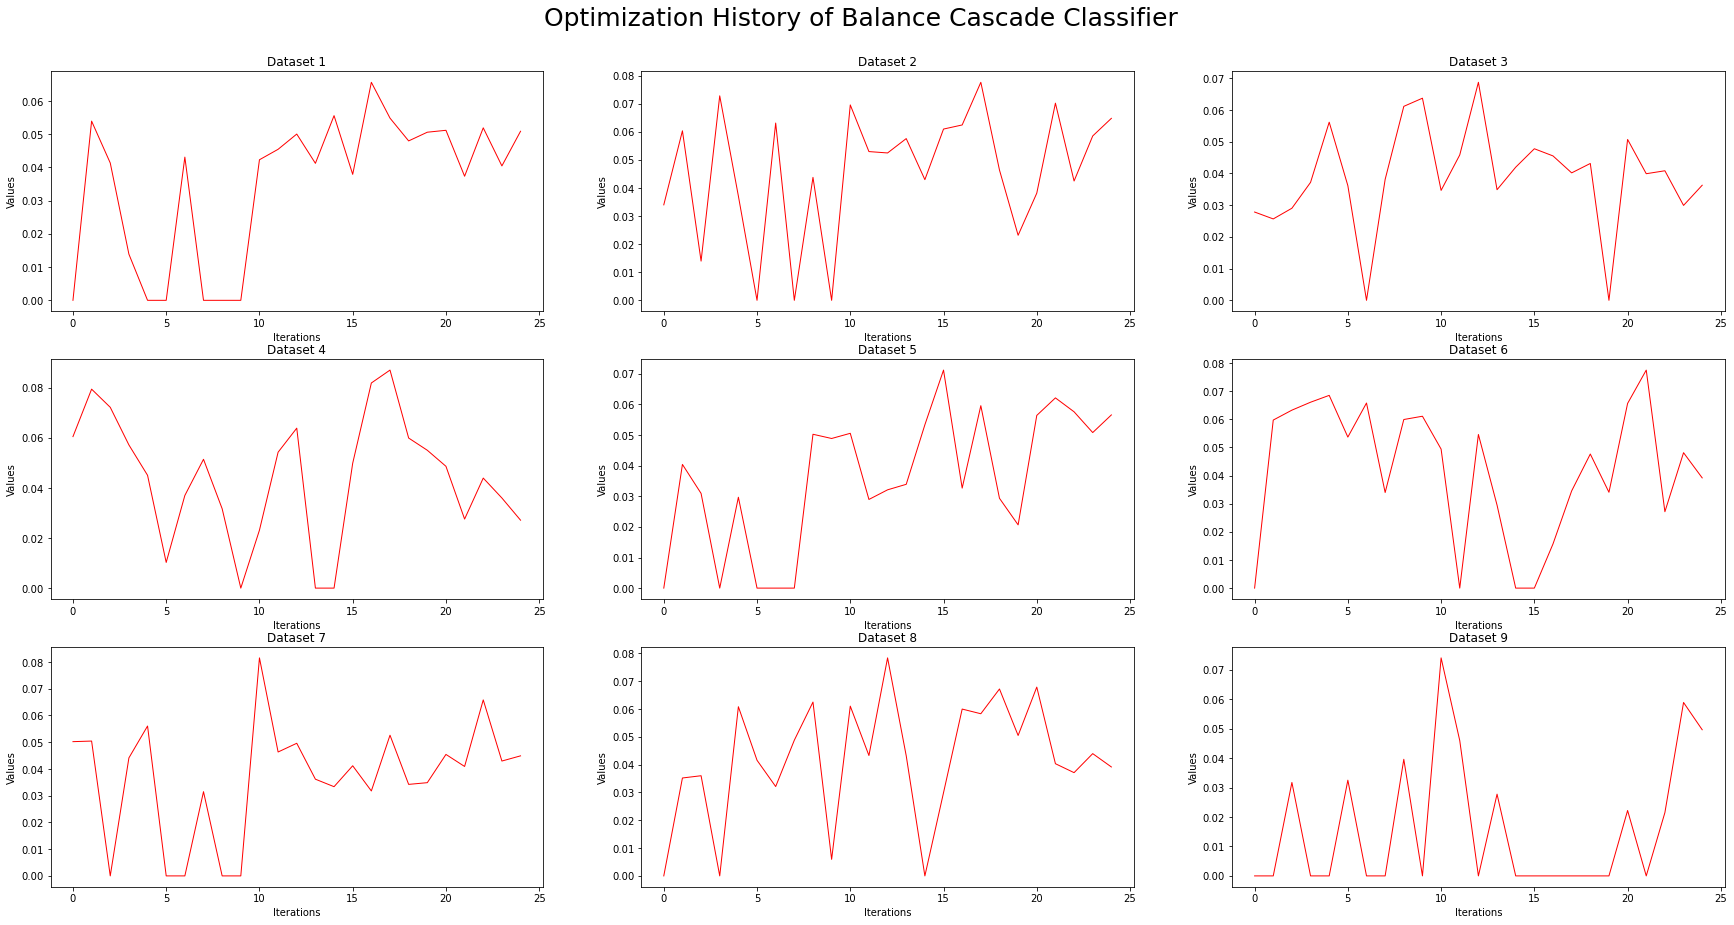

In [139]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 3, num_col = 3, model = 'Balance Cascade Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

### Classifier

#### Scheme 1


 Dataset 1:
Stop Oversampling !
Size before Undersampling: 16962
Size after Undersampling: 3084
Stop Oversampling !
Size before Undersampling: 10214
Size after Undersampling: 3084
Stop Oversampling !
Size before Undersampling: 6419
Size after Undersampling: 3084
Stop Oversampling !
Size before Undersampling: 4285
Size after Undersampling: 3084
Stop Oversampling !
Size before Undersampling: 3085
Stop Undersampling !
Precision: 0.001271905031091012 
Recall: 0.35294117647058826 
Aging Rate: 0.2909001212769019

 Dataset 2:
Stop Oversampling !
Size before Undersampling: 16577
Size after Undersampling: 3014
Stop Oversampling !
Size before Undersampling: 9982
Size after Undersampling: 3014
Stop Oversampling !
Size before Undersampling: 6273
Size after Undersampling: 3014
Stop Oversampling !
Size before Undersampling: 4188
Size after Undersampling: 3014
Stop Oversampling !
Size before Undersampling: 3015
Stop Undersampling !
Precision: 0.0010069366748713358 
Recall: 0.17647058823529413 
Aging

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


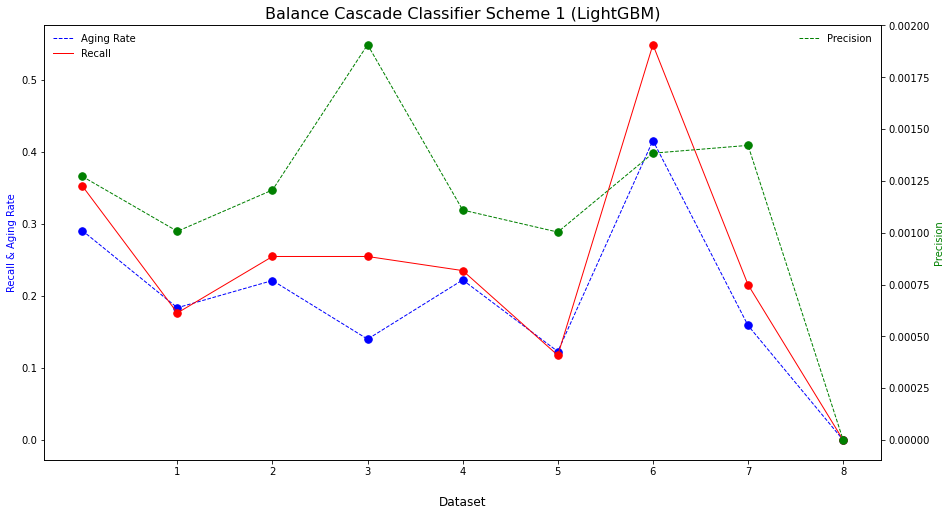

In [140]:
table_setC = runall_cascade(run_train, run_test, base_paramC, num_iter = 5)
line_chart(table_setC, title = 'Balance Cascade Classifier Scheme 1 (LightGBM)')

In [141]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,F1 Score,Score
dataset 1,10.000000,15420.0,1542.0,18.0,14134.0,33.0,34464.0,0.001272,0.352941,0.290900,1.213273,0.001267,0.280402
dataset 2,10.000000,15070.0,1507.0,9.0,8929.0,42.0,39669.0,0.001007,0.176471,0.183724,0.960519,0.001001,0.000000
dataset 3,10.000000,15160.0,1516.0,13.0,10764.0,38.0,37834.0,0.001206,0.254902,0.221526,1.150666,0.001201,0.195198
dataset 4,10.000000,15180.0,1518.0,13.0,6803.0,38.0,41795.0,0.001907,0.254902,0.140106,1.819355,0.001893,0.264208
dataset 5,9.863725,15200.0,1541.0,12.0,10803.0,39.0,37795.0,0.001110,0.235294,0.222307,1.058421,0.001104,0.169868
dataset 6,10.079576,15200.0,1508.0,6.0,5975.0,45.0,42623.0,0.001003,0.117647,0.122942,0.956932,0.000995,0.000000
dataset 7,10.174029,15200.0,1494.0,28.0,20206.0,23.0,28392.0,0.001384,0.549020,0.415918,1.320019,0.001380,0.462041
dataset 8,10.000000,15200.0,1520.0,11.0,7727.0,40.0,40871.0,0.001422,0.215686,0.159058,1.356025,0.001412,0.184838
dataset 9,10.000000,3040.0,304.0,0.0,0.0,51.0,48598.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


#### Scheme 2


 Dataset 1:
Size before Oversampling: 40092
Size after Oversampling: 46282
Size after Undersampling: 15464
Size before Oversampling: 33780
Size after Oversampling: 39931
Size after Undersampling: 15386
Size before Oversampling: 28502
Size after Oversampling: 34612
Size after Undersampling: 15304
Size before Oversampling: 24088
Size after Oversampling: 30288
Size after Undersampling: 15484
Size before Oversampling: 20397
Size after Oversampling: 26592
Size after Undersampling: 15474
Size before Oversampling: 17310
Size after Oversampling: 23509
Size after Undersampling: 15482
Size before Oversampling: 14729
Size after Oversampling: 20929
Size after Undersampling: 15484
Size before Oversampling: 12570
Size after Oversampling: 18681
Size after Undersampling: 15306
Size before Oversampling: 10765
Size after Oversampling: 16887
Size after Undersampling: 15328
Size before Oversampling: 9255
Size after Oversampling: 15303
Precision: 0.0012395187750637987 
Recall: 0.3333333333333333 
Aging Ra

Size after Undersampling: 3108
Size before Oversampling: 6660
Size after Oversampling: 7903
Size after Undersampling: 3094
Size before Oversampling: 5620
Size after Oversampling: 6842
Size after Undersampling: 3052
Size before Oversampling: 4750
Size after Oversampling: 5960
Size after Undersampling: 3028
Size before Oversampling: 4022
Size after Oversampling: 5225
Size after Undersampling: 3014
Size before Oversampling: 3414
Size after Oversampling: 4626
Size after Undersampling: 3032
Size before Oversampling: 2905
Size after Oversampling: 4091
Size after Undersampling: 2980
Size before Oversampling: 2480
Size after Oversampling: 3661
Size after Undersampling: 2970
Size before Oversampling: 2124
Size after Oversampling: 3359
Size after Undersampling: 3078
Size before Oversampling: 1826
Size after Oversampling: 3030
Precision: 0.0011631595643438722 
Recall: 0.6470588235294118 
Aging Rate: 0.5831774548294929


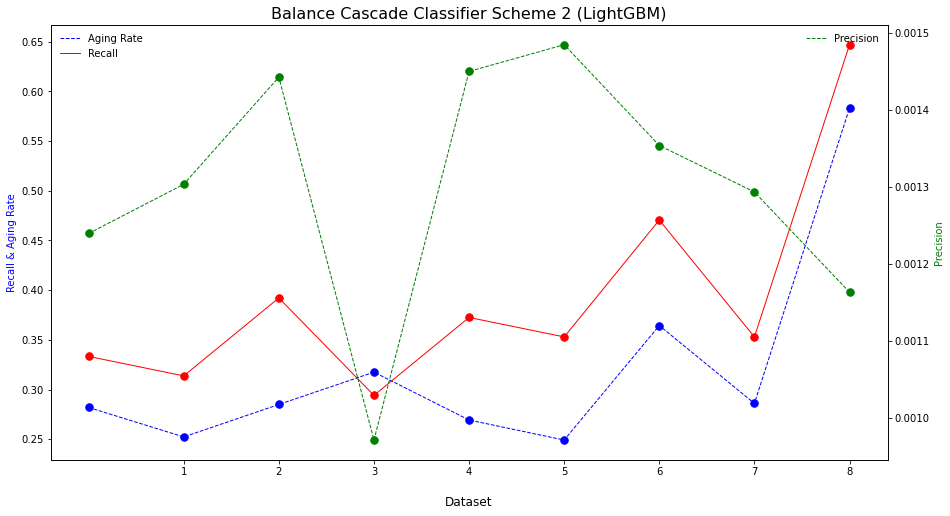

In [7]:
table_setC = runall_cascade(run_train, run_test, base_config = base_paramC, meta_config = meta_paramC)
line_chart(table_setC, title = 'Balance Cascade Classifier Scheme 2 (LightGBM)')

In [8]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,F1 Score,Score
dataset 1,25.000000,38550.0,1542.0,17.0,13698.0,34.0,34900.0,0.001240,0.333333,0.281917,1.182379,0.001235,0.260139
dataset 2,25.000000,37775.0,1511.0,16.0,12259.0,35.0,36339.0,0.001303,0.313725,0.252318,1.243375,0.001298,0.253484
dataset 3,25.000000,37900.0,1516.0,20.0,13843.0,31.0,34755.0,0.001443,0.392157,0.284960,1.376184,0.001437,0.339410
dataset 4,25.000000,37950.0,1518.0,15.0,15432.0,36.0,33166.0,0.000971,0.294118,0.317519,0.926298,0.000968,0.000000
dataset 5,25.049440,38000.0,1517.0,19.0,13083.0,32.0,35515.0,0.001450,0.372549,0.269317,1.383311,0.001445,0.323555
dataset 6,25.115664,38000.0,1513.0,18.0,12104.0,33.0,36494.0,0.001485,0.352941,0.249173,1.416452,0.001479,0.311400
dataset 7,25.182240,38000.0,1509.0,24.0,17703.0,27.0,30895.0,0.001354,0.470588,0.364386,1.291456,0.001350,0.390206
dataset 8,25.000000,38000.0,1520.0,18.0,13898.0,33.0,34700.0,0.001293,0.352941,0.286049,1.233848,0.001289,0.283668
dataset 9,25.000000,7600.0,304.0,33.0,28338.0,18.0,20260.0,0.001163,0.647059,0.583177,1.109540,0.001161,0.483010


### Export

In [142]:
savedate = '20220315'
TPE_multi = False
scheme = 1

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = f'BC_scheme{scheme}_iter5_over5_rus'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = f'BC_scheme{scheme}_iter5_over5_rus')